In [74]:
import pandas as pd

In [75]:
custom_date_parser = lambda x: datetime.strptime(x, "%Y-%d-%m %H:%M:%S")
df = pd.read_csv('com-data.csv', parse_dates = True, date_parser = custom_date_parser)
df.drop('Timestamp (Unix)', axis = 1, inplace = True)
df['Timestamp (Day Time(cst))'] = pd.to_datetime(df['Timestamp (Day Time(cst))'])
df.set_index('Timestamp (Day Time(cst))')

,Brazil,China,Corn,EU,India,Russia,Soybean,Wheat,Gold
Timestamp (Day Time(cst)),,,,,,,,,
2022-02-10 17:00:00,5.251878,6.359248,6.414742,0.875090,75.630466,75.090875,15.715228,7.099857,58.121884
2022-02-10 17:01:00,5.251406,6.358867,6.415511,0.875090,75.635000,75.048859,15.715699,7.096311,58.081238
2022-02-10 17:01:00,5.251406,6.358867,6.415511,0.875090,75.635000,75.048859,15.715699,7.096311,58.081238
2022-02-10 17:10:00,5.252695,6.355434,6.414101,0.876465,75.575788,75.096423,15.715699,7.101135,58.082399
2022-02-10 17:14:00,5.255236,6.357214,6.413908,0.875985,75.578118,75.079524,15.721196,7.100780,58.109684
...,...,...,...,...,...,...,...,...,...
2022-02-15 13:14:00,5.184234,6.344606,6.363618,0.880265,75.263861,75.724890,15.497137,7.219598,59.634100
2022-02-15 12:30:00,5.188102,6.343848,6.362029,0.880085,75.263233,75.706911,15.479629,7.223785,59.597430
2022-02-15 12:36:00,5.185357,6.344357,6.354726,0.880105,75.284702,75.742428,15.475608,7.223279,59.623807


In [76]:
df = df[2400:].copy()

In [77]:
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from pylab import rcParams
import matplotlib
from matplotlib import pyplot as plt

No handles with labels found to put in legend.


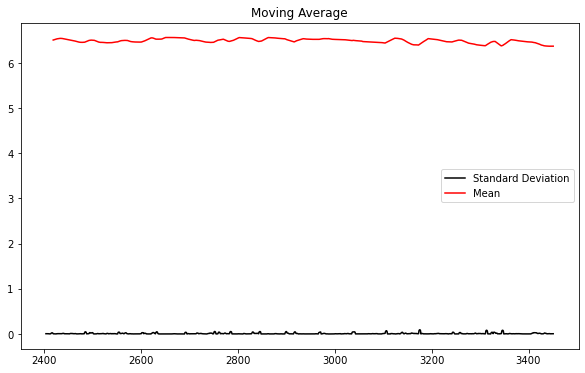

In [78]:
#if not stationary then eliminate trend
#Eliminate trend
df_corn = df['Corn']
rcParams['figure.figsize'] = 10, 6
df_log = df_corn
moving_avg = df_log.rolling(20).mean()
std_dev = df_log.rolling(5).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

In [79]:
df_log

2400    6.487569
2401    6.474716
2402    6.479455
2403    6.490553
2404    6.484258
          ...   
3447    6.363618
3448    6.362029
3449    6.354726
3450    6.368981
3451    6.367915
Name: Corn, Length: 1052, dtype: float64

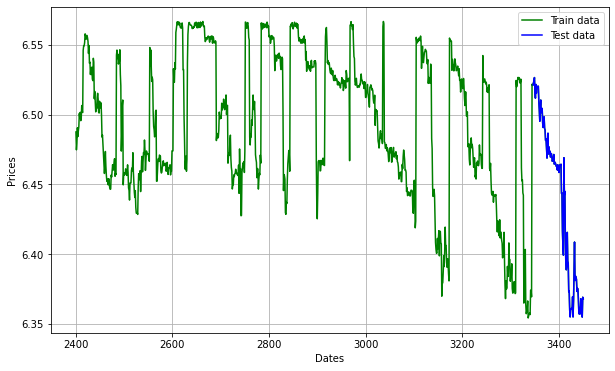

In [90]:
size = round(len(df_log) * .9)
train, test = df_log[0:size], df_log[size:]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6233.191, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-4977.024, Time=0.46 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.64 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-4975.471, Time=0.62 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-4942.400, Time=0.80 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-5011.506, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-3817.569, Time=0.20 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-5013.480, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-2922.246, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-5011.504, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-5008.99

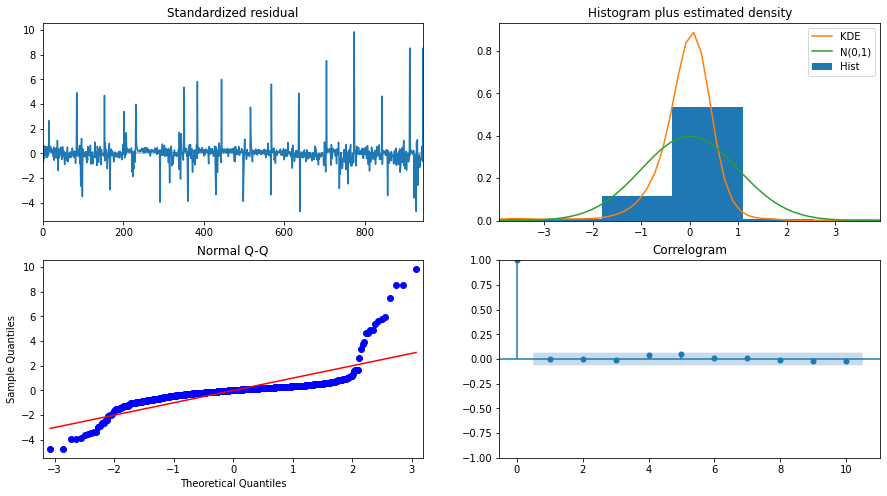

In [81]:
model_autoARIMA = auto_arima(train, start_p=0, start_q=0,test='adf',max_p=3, max_q=3,m=1,d=None,seasonal=False,start_P=0, D=0,trace=True,error_action='ignore',suppress_warnings=True,stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [91]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df['Corn'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -4.823379
p-value: 0.000049


In [92]:
model = ARIMA(train, order=(1, 0, 0))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                   Corn   No. Observations:                  947
Model:                 ARIMA(1, 0, 0)   Log Likelihood                2509.740
Date:                Wed, 16 Feb 2022   AIC                          -5013.480
Time:                        09:48:59   BIC                          -4998.920
Sample:                             0   HQIC                         -5007.931
                                - 947                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.4950      0.012    526.147      0.000       6.471       6.519
ar.L1          0.9438      0.015     64.631      0.000       0.915       0.972
sigma2         0.0003   6.28e-06     46.431      0.0

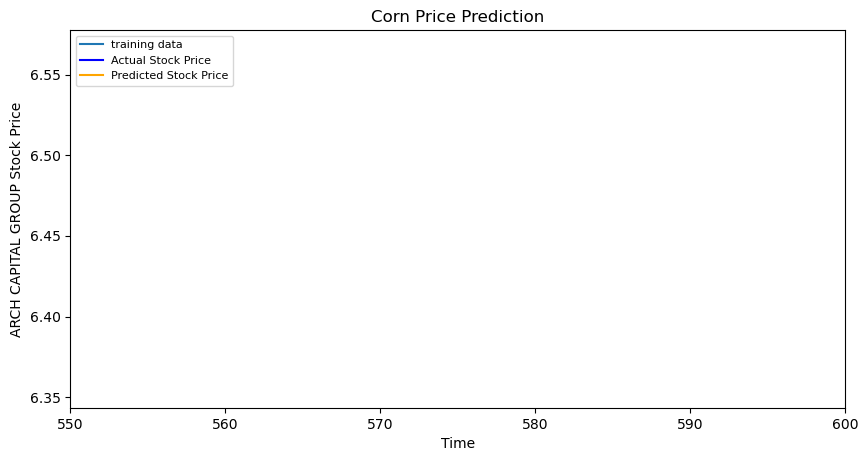

In [93]:
# Forecast
fc = fitted.forecast(len(test), alpha=0.05)  # 95% conf
# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
# lower_series = pd.Series(conf[:, 0], index=test.index)
# upper_series = pd.Series(conf[:, 1], index=test.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train, label='training data')
plt.plot(test, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
# plt.fill_between(lower_series.index, lower_series, upper_series, 
#                  color='k', alpha=.10)
plt.title('Corn Price Prediction')
plt.xlabel('Time')
plt.ylabel('ARCH CAPITAL GROUP Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.xlim([550, 600])
plt.show()

In [87]:
# report performance
mse = mean_squared_error(test, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test)/np.abs(test))
print('MAPE: '+str(mape))

MSE: 0.006018256921480275
MAE: 0.05918377031032507
RMSE: 0.07757742533418002
MAPE: 0.009255823040170448


In [95]:
from joblib import dump, load
dump(fitted, 'corn_arima.model')

['corn_arima.model']

In [89]:
fc_series

3347    6.519542
3348    6.518165
3349    6.516866
3350    6.515640
3351    6.514482
          ...   
3447    6.495110
3448    6.495105
3449    6.495101
3450    6.495098
3451    6.495094
Name: predicted_mean, Length: 105, dtype: float64

In [94]:
test

3347    6.521218
3348    6.522804
3349    6.524585
3350    6.526586
3351    6.516066
          ...   
3447    6.363618
3448    6.362029
3449    6.354726
3450    6.368981
3451    6.367915
Name: Corn, Length: 105, dtype: float64